In [2]:
from qwak.qwak import QWAK
from utils.plotTools import searchProbStepsPlotting,searchProbStepsPlotting2

import networkx as nx
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from math import sqrt, ceil, pow
import scipy.special as sp
from scipy.linalg import expm
import sympy as simp
import math
from qwak.State import State
from qwak.Operator import Operator
from qwak.QuantumWalk import QuantumWalk
from qwak.ProbabilityDistribution import ProbabilityDistribution
from qwak.qwak import QWAK
import copy
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

from scipy.ndimage import gaussian_filter

In [3]:
def write_nested_list_to_file(file_path, nested_lst):
    """
    Write a nested list of elements to a text file.
    
    :param file_path: the file path where to write the nested list
    :param nested_lst: the nested list of elements to write
    """
    with open(file_path, 'w') as f:
        for lst in nested_lst:
            for item in lst:
                f.write(f"{item} ")
            f.write("\n")

def load_nested_list_from_file(file_path):
    """
    Load a nested list of float elements from a text file.
    
    :param file_path: the file path to load the nested list from
    :return: the nested list of float elements loaded from the file
    """
    nested_lst = []
    with open(file_path, 'r') as f:
        for line in f:
            lst = [float(item) for item in line.strip().split()]
            nested_lst.append(lst)
    return nested_lst

def plotSearch(N,probT,tSpace,configVec):
    plotName = ""
    for T,walk,config,n in zip(tSpace,probT,configVec,N):
        #print(config)
        plt.plot(T,walk,color=config[0],linestyle=config[1],label="N=%s"%n)
        plt.vlines(max(T),0,1,color=config[0],linestyle=config[2])
        plt.legend()
        plt.xlabel("Number of steps")
        plt.ylabel("Probability of marked elements")
    for n in N:
        plotName+='_'+str(n)
    plt.savefig(r"C:\Users\jaime\Documents\GitHub\QWAK\Notebook\Output\\"+f"Search{plotName}")
    # plt.clf()
    
def plotSearch2(N,markedList, probT, tSpace, configVec,labels):
    %matplotlib inline
    plotName = ""
    fig = plt.figure()
    for T, walk, config, marked, label in zip(tSpace, probT, configVec, markedList,labels):
        plt.plot(T, walk, color=config[0], linestyle=config[1], label=label)
        plt.vlines(max(T), 0, max(probT[0]), color=config[0], linestyle=config[2])
        #plt.legend()
        plt.xlabel("Time")
        plt.ylabel("Probability of marked elements")
    for marked in markedList:
        plotName += '_' + str(len(marked))
    return fig
    

In [4]:
n=200
t = (np.pi/2) * np.sqrt(n)
gamma = 1/n
initCond = list(range(0,n))
graph = nx.complete_graph(n)

qw = QWAK(graph=graph,gamma=gamma,markedElements=[(n//2,-1)],laplacian=False)
qw.runWalk(time=t,initStateList=initCond)
# plt.plot(qw.getProbVec(),label='CTQW')
# plt.legend()

In [5]:
def multiple_complete_qwak(N,markedElementMatrix,gamma,initCond,graph,numberOfWalks,samples):
    markedProbMatrix = []
    timeMatrix = []
    for markedElements in markedElementMatrix:
        t = (np.pi/2) * np.sqrt(N/len(markedElements))
        print(t)
        timeList = [ x for x in np.linspace(0,t,samples)]
        qw = QWAK(graph=graph,gamma=gamma,initStateList=initCond,markedElements=markedElements)
        qw.runMultipleWalks(timeList = timeList)
        solutionProbList = searchProbStepsPlotting(qw)
        markedProbMatrix.append(solutionProbList)
        timeMatrix.append(timeList)
    return timeMatrix , markedProbMatrix

In [6]:
numberOfWalks = 3
samples = 200

n = 9
N= 2**n
t = (np.pi/2) * np.sqrt(N)
timeList = [ x for x in np.linspace(0,t,samples)]
# print(timeList)
gamma = 1/N
initCond = list(range(0,N))
graph = nx.complete_graph(N)
markedElementsMatrix = [ [(x,-1) for x in range(0,N//16)], [(x,-1) for x in range(0,N//8)], [(x,-1) for x in range(0,N//4)] ]



In [7]:
timeMatrix_file = f'Datasets/CompleteSearch/timeMatrix_N{N}_NWALKS{numberOfWalks}_S{samples}.txt'
markedProbMatrix_file = f'Datasets/CompleteSearch/markedProbMatrix_N{N}_NWALKS{numberOfWalks}_S{samples}.txt'

if os.path.exists(timeMatrix_file) and os.path.exists(markedProbMatrix_file):
    timeMatrix = load_nested_list_from_file(timeMatrix_file)
    markedProbMatrix = load_nested_list_from_file(markedProbMatrix_file)
    print('File exists!')
else:
    print('File Doesnt Exist!')
    timeMatrix,markedProbMatrix = multiple_complete_qwak(N=N,markedElementMatrix = markedElements,gamma=gamma,
                                                         initCond=initCond,graph=graph,numberOfWalks = numberOfWalks, 
                                                         samples = samples)
    if not os.path.exists(timeMatrix_file):
        write_nested_list_to_file(timeMatrix_file, timeMatrix)
    if not os.path.exists(markedProbMatrix_file):
        write_nested_list_to_file(markedProbMatrix_file, markedProbMatrix)


File exists!


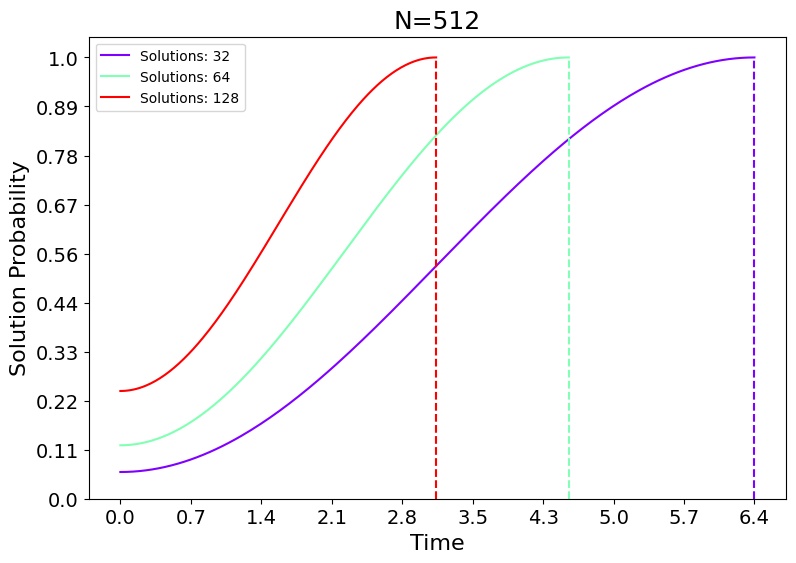

In [8]:
def plot_search(markedList, probT, tSpace, configVec, x_num_ticks=5, y_num_ticks=5, x_round_val=3, y_round_val=3, filepath=None,
                xlabel='Number of steps', ylabel='Probability of marked elements', cbar_label='Gamma', font_size=12, figsize=(8, 6),
                cbar_num_ticks=None, cbar_tick_labels=None, plot_title='Hypercube Search'):

    fig, ax = plt.subplots(figsize=figsize)

    for i, (T, walk, config, marked) in enumerate(zip(tSpace, probT, configVec, markedList)):
        max_prob = np.max(walk)
        max_prob_t = T[np.argmax(walk)]
        ax.plot(T, walk, color=config[0], linestyle=config[1], label=f'Solutions: {len(marked)}')
        ax.axvline(max_prob_t, color=config[0], linestyle='dashed', linewidth=1.5,
               ymax=max_prob/ax.get_ylim()[1])
        ax.set_xlabel(xlabel, fontsize=font_size + 2)
        ax.set_ylabel(ylabel, fontsize=font_size + 2)
        ax.set_title(plot_title, fontsize=font_size+4)

    ax.tick_params(axis='both', which='major', labelsize=font_size)

    num_t_ticks = min(y_num_ticks, len(tSpace[0]))
    t_tick_labels = np.round(np.linspace(min(tSpace[0]), max(tSpace[0]), num_t_ticks), y_round_val)

    ax.set_yticks(np.linspace(0, np.max(probT), num_t_ticks))
    ax.set_yticklabels(np.round(np.linspace(0, np.max(probT), num_t_ticks), y_round_val))

    num_x_ticks = min(x_num_ticks, len(tSpace[0]))
    x_tick_labels = np.round(np.linspace(min(tSpace[0]), max(tSpace[0]), num_x_ticks), x_round_val)

    ax.set_xticks(np.linspace(min(tSpace[0]), max(tSpace[0]), num_x_ticks))
    ax.set_xticklabels(x_tick_labels)

    ax.legend()

    if filepath is not None:
        plt.savefig(filepath, bbox_inches='tight')
        plt.show()
    else:
        plt.show()
        
colors = plt.cm.rainbow(np.linspace(0, 1, numberOfWalks))
lines = ['-']*len(timeList)
configVec = list(zip(colors,lines))

x_num_ticks=10
y_num_ticks=10
x_round_val=1
y_round_val=2

filepath=f'Output/CompleteSearch/completePlot_N{N}_NWALKS{numberOfWalks}_S{samples}.png'

plot_title = f'N={N}'

xlabel='Time'
ylabel='Solution Probability'

font_size=14
figsize=(9, 6)

plot_search(markedList=markedElementsMatrix, probT=markedProbMatrix, tSpace=timeMatrix, configVec=configVec,
            x_num_ticks=x_num_ticks, y_num_ticks=y_num_ticks, x_round_val=x_round_val, y_round_val=y_round_val, 
            filepath=filepath,xlabel=xlabel, ylabel=ylabel, font_size=font_size, 
            figsize=figsize,plot_title=plot_title)